In [36]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Linear Model
from statsmodels.formula.api import ols

import evaluate

from sklearn.metrics import mean_squared_error
from math import sqrt

from pydataset import data

## Evaluating simple linear regressions on lemonade data with other features
### 1. Create a dataframe from the csv

In [2]:
url = "https://gist.githubusercontent.com/ryanorsinger/9867c96ddb56626e9aac94d8e92dabdf/raw/45f9a36a8871ac0e24317704ed0072c9dded1327/lemonade_regression.csv"
df = pd.read_csv(url)
df.head()

,temperature,rainfall,flyers,sales
0,27.0,2.00,15,10
1,28.9,1.33,15,13
2,34.5,1.33,27,15
3,44.1,1.05,28,17
4,42.4,1.00,33,18


In [3]:
# Add column 'log_trainfall'

df['log_rainfall'] = np.log(df.rainfall)
df.head()

,temperature,rainfall,flyers,sales,log_rainfall
0,27.0,2.00,15,10,0.693147
1,28.9,1.33,15,13,0.285179
2,34.5,1.33,27,15,0.285179
3,44.1,1.05,28,17,0.048790
4,42.4,1.00,33,18,0.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   temperature   365 non-null    float64
 1   rainfall      365 non-null    float64
 2   flyers        365 non-null    int64  
 3   sales         365 non-null    int64  
 4   log_rainfall  365 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 14.4 KB


### 2. Make a baseline for predicting sales. (The mean is a good baseline)

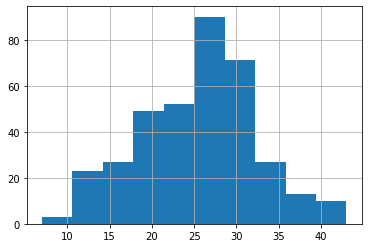

In [20]:
# Visualize the target variable 'sales' by distribution plot

df.sales.hist()

### 3. Create a new dataframe to hold residuals.

In [ ]:
evaluate = df[['flyers', 'sales']]

### 4. Calculate the baseline residuals.

In [27]:
# Since sales are reasonably normally distributed, the mean will be used as the baseline

baseline = df.sales.mean()
baseline

25.323287671232876

### 5. Use ols from statsmodels to create a simple linear regression (1 independent variable, 1 dependent variable) to predict sales using flyers.

In [32]:
# Use statsmodels OLS to build/identify a super simple linear model

model = ols('sales ~ flyers', df).fit()
model

### 6. Use the .predict method from ols to produce all of our predictions. Add these predictions to the data

In [40]:
model.predict()[:5]

array([14.67375373, 14.67375373, 19.7279263 , 20.14910735, 22.25501259])

### 7. Calculate that model's residuals.

In [24]:
df.columns

Index(['temperature', 'rainfall', 'flyers', 'sales', 'log_rainfall'], dtype='object')

In [36]:
# Calculate residuals

evaluate['baseline'] = baseline
evaluate['sales_pred'] = model.predict()
evaluate['baseline_residual'] = evaluate.sales - evaluate.baseline
evaluate['model_residual'] = evaluate.sales - evaluate.sales_pred

In [37]:
evaluate.head()

,flyers,sales,baseline,sales_pred,baseline_residual,model_residual
0,15,10,25.323288,14.673754,-15.323288,-4.673754
1,15,13,25.323288,14.673754,-12.323288,-1.673754
2,27,15,25.323288,19.727926,-10.323288,-4.727926
3,28,17,25.323288,20.149107,-8.323288,-3.149107
4,33,18,25.323288,22.255013,-7.323288,-4.255013


In [39]:
baseline_sse = (evaluate.baseline_residual**2).sum()
model_sse = (evaluate.model_residual**2).sum()

baseline_sse, model_sse

(17297.85205479452, 6083.326244705024)

In [42]:
# Compute MSE

mse = mean_squared_error(evaluate.sales, evaluate.sales_pred)
mse

16.666647245767187

In [43]:
# Compute MSE by the naive method

mse = model_sse / evaluate.shape[0]
mse

16.666647245767187

In [44]:
rmse = sqrt(mse)
rmse

4.082480526073233

### 8. Evaluate that model's performance and answer if the model is significant.
- $R^2$: measure the strength of the relationship
- f_pval: determine if our test if significant
- $H_0$: The model not built with the independent variables explain the relationship
- $H_a$: The model built on independent variabl explains the relationship, validates $R^2$

In [45]:
r2 = model.rsquared
r2

0.648318980562741

In [48]:
f_pval = model.f_pvalue
f_pval, f_pval < 0.05

(2.193718738113383e-84, True)

### 9. Plot residuals
- residual x actual y
- residual plot

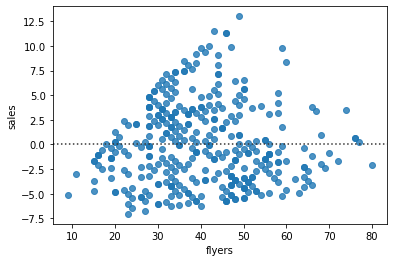

In [62]:
# Residual plot

sns.residplot(data=evaluate, y='sales', x='flyers')

In [63]:
evaluate.model_residual.agg(['min','max'])

min    -7.043202
max    13.006091
Name: model_residual, dtype: float64

In [19]:
def plot_residuals(actual, predicted):
    residuals = actual - predicted
    plt.hlines(0, actual.min(), actual.max(), ls=':')
    plt.scatter(actual, residuals)
    plt.ylabel('residual ($y - \hat{y}$)')
    plt.xlabel('actual value ($y$)')
    plt.title('Actual vs Residual')
    return plt.gca()

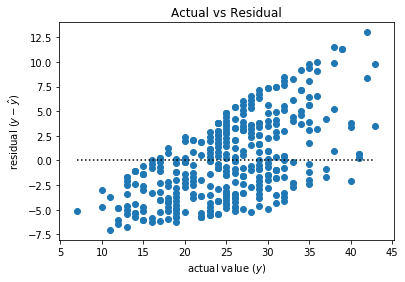

In [66]:
plot_residuals(evaluate.sales, evaluate.sales_pred)

### Evaluate feature `rainfall`

In [67]:
df.head()

,temperature,rainfall,flyers,sales,log_rainfall
0,27.0,2.00,15,10,0.693147
1,28.9,1.33,15,13,0.285179
2,34.5,1.33,27,15,0.285179
3,44.1,1.05,28,17,0.048790
4,42.4,1.00,33,18,0.000000


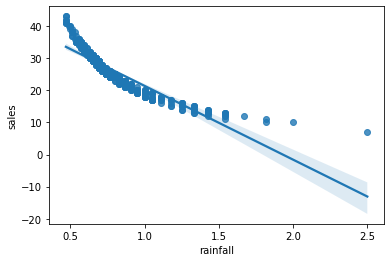

In [17]:
sns.regplot(data=df, x='rainfall', y='sales')

In [68]:
# Create formula by string concatenation

'sales' + ' ~ ' + 'rainfall'

'sales ~ rainfall'

In [7]:
def evaluate_slr(target, feature, df):
    baseline = df[target].mean()
    formula = target + ' ~ ' + feature
    model = ols(formula, df).fit()
    evaluate = df[[feature, target]]
    evaluate['baseline'] = baseline
    evaluate[(target + '_pred')] = model.predict()
    evaluate['baseline_residual'] = evaluate[target] - evaluate.baseline
    evaluate['model_residual'] = evaluate[target] - evaluate[(target + '_pred')]
    return evaluate

In [8]:
evaluate_slr('sales', 'flyers', df).head()

,flyers,sales,baseline,sales_pred,baseline_residual,model_residual
0,15,10,25.323288,14.673754,-15.323288,-4.673754
1,15,13,25.323288,14.673754,-12.323288,-1.673754
2,27,15,25.323288,19.727926,-10.323288,-4.727926
3,28,17,25.323288,20.149107,-8.323288,-3.149107
4,33,18,25.323288,22.255013,-7.323288,-4.255013


In [16]:
evaluate = evaluate_slr('sales', 'rainfall', df)
evaluate.head()

,rainfall,sales,baseline,sales_pred,baseline_residual,model_residual
0,2.00,10,25.323288,-1.599602,-15.323288,11.599602
1,1.33,13,25.323288,13.773142,-12.323288,-0.773142
2,1.33,15,25.323288,13.773142,-10.323288,1.226858
3,1.05,17,25.323288,20.197573,-8.323288,-3.197573
4,1.00,18,25.323288,21.344793,-7.323288,-3.344793


In [12]:
# Compute SSE

baseline_sse = (evaluate.baseline_residual**2).sum()
model_sse = (evaluate.model_residual**2).sum()

baseline_sse, model_sse

(17297.85205479452, 2998.2371310300655)

In [13]:
mse = mean_squared_error(evaluate.sales, evaluate.sales_pred)
mse

8.21434830419196

In [14]:
rmse = sqrt(mse)
rmse

2.866068440249109

In [15]:
model = ols('sales ~ rainfall', df).fit()

r2 = model.rsquared

f_pval = model.f_pvalue

r2, f_pval, f_pval < 0.05

(0.8266699748886435, 3.2988846597381e-140, True)

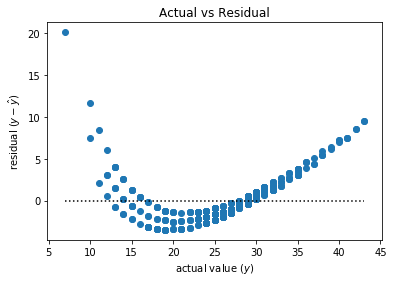

In [20]:
plot_residuals(evaluate.sales, evaluate.sales_pred)

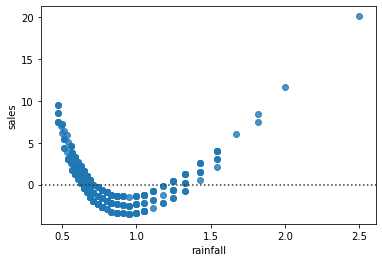

In [21]:
sns.residplot(data=evaluate, y='sales', x='rainfall')

### Evaluate feature `log_rainfall`

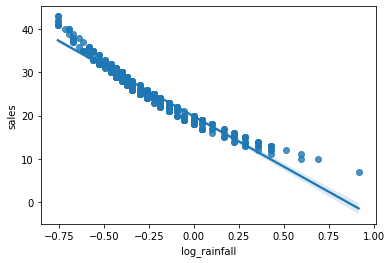

In [22]:
sns.regplot(data=df, x='log_rainfall', y='sales')

In [23]:
evaluate = evaluate_slr('sales', 'log_rainfall', df)
evaluate.head()

,log_rainfall,sales,baseline,sales_pred,baseline_residual,model_residual
0,0.693147,10,25.323288,3.688573,-15.323288,6.311427
1,0.285179,13,25.323288,13.198359,-12.323288,-0.198359
2,0.285179,15,25.323288,13.198359,-10.323288,1.801641
3,0.048790,17,25.323288,18.708608,-8.323288,-1.708608
4,0.000000,18,25.323288,19.845912,-7.323288,-1.845912


In [24]:
# Compute SSE

baseline_sse = (evaluate.baseline_residual**2).sum()
model_sse = (evaluate.model_residual**2).sum()

baseline_sse, model_sse

(17297.85205479452, 952.325347429345)

In [25]:
mse = mean_squared_error(evaluate.sales, evaluate.sales_pred)
rmse = sqrt(mse)
mse, rmse

(2.609110540902315, 1.6152741380033036)

In [27]:
model = ols('sales ~ log_rainfall', df).fit()

r2 = model.rsquared

f_pval = model.f_pvalue

r2, f_pval, f_pval < 0.05

(0.9449454565565333, 1.2242624097795882e-230, True)

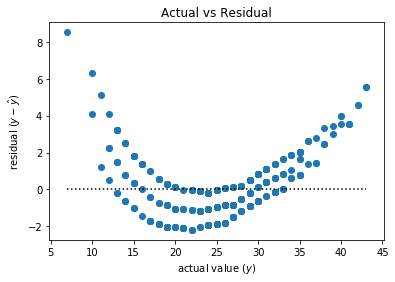

In [28]:
plot_residuals(evaluate.sales, evaluate.sales_pred)

### Evaluate feature `temperature`

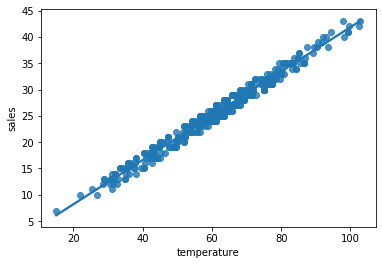

In [29]:
sns.regplot(data=df, x='temperature', y='sales')

In [30]:
evaluate = evaluate_slr('sales', 'temperature', df)
evaluate.head()

,temperature,sales,baseline,sales_pred,baseline_residual,model_residual
0,27.0,10,25.323288,11.112301,-15.323288,-1.112301
1,28.9,13,25.323288,11.912772,-12.323288,1.087228
2,34.5,15,25.323288,14.272055,-10.323288,0.727945
3,44.1,17,25.323288,18.316540,-8.323288,-1.316540
4,42.4,18,25.323288,17.600329,-7.323288,0.399671


In [31]:
# Compute SSE

baseline_sse = (evaluate.baseline_residual**2).sum()
model_sse = (evaluate.model_residual**2).sum()

baseline_sse, model_sse

(17297.85205479452, 349.977815203168)

In [32]:
mse = mean_squared_error(evaluate.sales, evaluate.sales_pred)
rmse = sqrt(mse)
mse, rmse

(0.9588433293237479, 0.979205458177061)

In [33]:
model = ols('sales ~ temperature', df).fit()

r2 = model.rsquared

f_pval = model.f_pvalue

r2, f_pval, f_pval < 0.05

(0.9797675564518333, 1.492364042585725e-309, True)

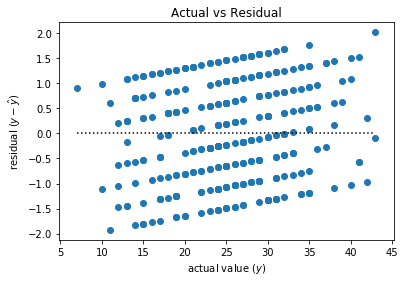

In [34]:
plot_residuals(evaluate.sales, evaluate.sales_pred)

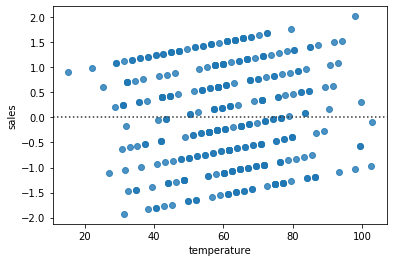

In [35]:
sns.residplot(data=evaluate, y='sales', x='temperature')

### Tips dataset

In [37]:
df = data('tips')
df.head()

,total_bill,tip,sex,smoker,day,time,size
1,16.99,1.01,Female,No,Sun,Dinner,2
2,10.34,1.66,Male,No,Sun,Dinner,3
3,21.01,3.50,Male,No,Sun,Dinner,3
4,23.68,3.31,Male,No,Sun,Dinner,2
5,24.59,3.61,Female,No,Sun,Dinner,4


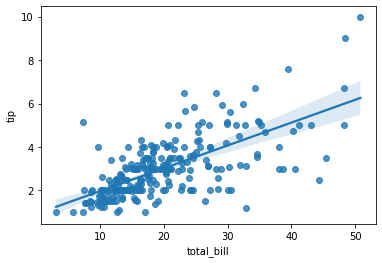

In [38]:
sns.regplot(data=df, x='total_bill', y='tip')

In [41]:
df.tip.mean()

2.9982786885245902

In [39]:
evaluate = evaluate_slr('tip', 'total_bill', df)
evaluate.head()

,total_bill,tip,baseline,tip_pred,baseline_residual,model_residual
1,16.99,1.01,2.998279,2.704636,-1.988279,-1.694636
2,10.34,1.66,2.998279,2.006223,-1.338279,-0.346223
3,21.01,3.50,2.998279,3.126835,0.501721,0.373165
4,23.68,3.31,2.998279,3.407250,0.311721,-0.097250
5,24.59,3.61,2.998279,3.502822,0.611721,0.107178


In [40]:
# Compute SSE

baseline_sse = (evaluate.baseline_residual**2).sum()
model_sse = (evaluate.model_residual**2).sum()

baseline_sse, model_sse

(465.2124770491804, 252.788743850776)

In [43]:
mse = mean_squared_error(evaluate.tip, evaluate.tip_pred)
rmse = sqrt(mse)
mse, rmse

(1.036019442011377, 1.0178504025697377)

In [44]:
model = ols('tip ~ total_bill', df).fit()

r2 = model.rsquared

f_pval = model.f_pvalue

r2, f_pval, f_pval < 0.05

(0.45661658635167646, 6.692470646863376e-34, True)

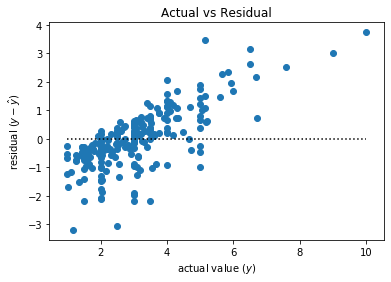

In [45]:
plot_residuals(evaluate.tip, evaluate.tip_pred)

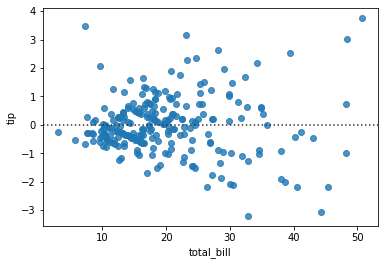

In [47]:
sns.residplot(data=evaluate, y='tip', x='total_bill')